Model Workflow
Data Loading &  Processing

Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)

Further Feature engineering: implementing Time Series 

- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization

Feature Selection through Pre-calculated Technical Indicators 

Trend prediction: inputs - SMA, EMA, using Linear regression (OLS), or support vector machine
Market Regime Detection: inputs - RSI, ATR, SMA using K-means Clustering
Buy/Sell Signals for Binary Classification: inputs - RSI, MACD, OBV, using Random Forest Classifier 

Model Training & Prediction: Machine Learning

Time Series Modelling: ARIMA for short -term price, GARCH for volatility forecasting 
Price Forecasting: LSTM, utilizing keras to implement long-term price forecasting
Strategy Implementation:
Combine signals and implement reinforcement learning to create a trading strategy

Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


In [1]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago from Janauary as train data 
end_date = datetime(2025, 1, 1) 
start_date = end_date - timedelta(days=366)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


   timestamp      open      high       low     close       volume
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327
     timestamp      open      high       low     close       volume
451 2025-03-27  86909.17  87756.39  85800.00  87232.01  17098.03897
452 2025-03-28  87232.01  87515.67  83585.00  84424.38  27182.73169
453 2025-03-29  84424.38  84624.73  81644.81  82648.54  11696.39864
454 2025-03-30  82648.53  83534.64  81565.00  82389.99   9864.49508
455 2025-03-31  82390.00  83746.23  81278.52  83396.96  14543.87641


In [2]:
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA_5'] = SMAIndicator(data['close'], window=5).sma_indicator()
    data['SMA_10'] = SMAIndicator(data['close'], window=10).sma_indicator()
    data['SMA_15'] = SMAIndicator(data['close'], window=15).sma_indicator()
    data['SMA_30'] = SMAIndicator(data['close'], window=30).sma_indicator()
    data['EMA_9'] = EMAIndicator(data['close'], window=9).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_hist'] = macd.macd_diff()
    # data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    # data['MFI'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=14)
    # data['ATR'] = AverageTrueRange(data['high'], data['low'], data['close'], window=14).average_true_range()
    # bands = BollingerBands(data['close'], window=20, window_dev = 2)
    # data['upper_band'] = bands.bollinger_hband()
    # data['middle_band'] = bands.bollinger_mavg()
    # data['lower_band'] = bands.bollinger_lband() 
    # data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    # Lagged Close prices
    data['close_lag_1'] = data['close'].shift(1)
    data['close_lag_2'] = data['close'].shift(2)
    #lead close prices
    for n in [1, 2, 5, 10, 20, 30]:
        data[f'close_{n}_ahead'] = data['close'].shift(-n)
    data['log_return'] = np.log(data['close']).diff()
    data['return_1'] =  (data['close_1_ahead'] - data['close']) / data['close']  
    
    return data 

#handle missing values
def handle_missing_data(data):
    data.ffill(inplace=True)
    data.bfill(inplace = True)
    return data 

# Normalization
def normalize_data(df):
    scaler = StandardScaler()
    df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']] = scaler.fit_transform(df[['SMA', 'EMA', 'MACD', 'OBV', 'ATR']])
    return df

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
# btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())


   timestamp      open      high       low     close       volume     SMA_5  \
0 2024-01-01  42283.58  44184.10  42180.77  44179.55  27174.29903  44053.58   
1 2024-01-02  44179.55  45879.63  44148.34  44946.91  65146.40661  44053.58   
2 2024-01-03  44946.91  45500.00  40750.00  42845.23  81194.55173  44053.58   
3 2024-01-04  42845.23  44729.58  42613.77  44151.10  48038.06334  44053.58   
4 2024-01-05  44151.10  44357.46  42450.00  44145.11  48075.25327  44053.58   

      SMA_10        SMA_15        SMA_30  ...  close_lag_1  close_lag_2  \
0  44788.027  44272.906667  42933.371333  ...     44179.55     44179.55   
1  44788.027  44272.906667  42933.371333  ...     44179.55     44179.55   
2  44788.027  44272.906667  42933.371333  ...     44946.91     44179.55   
3  44788.027  44272.906667  42933.371333  ...     42845.23     44946.91   
4  44788.027  44272.906667  42933.371333  ...     44151.10     42845.23   

   close_1_ahead  close_2_ahead  close_5_ahead  close_10_ahead  \
0       

In [3]:
print(btc_data.columns)
# check if there are any missing values
print(btc_data.isnull().sum())

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead',
       'close_30_ahead', 'log_return', 'return_1'],
      dtype='object')
timestamp         0
open              0
high              0
low               0
close             0
volume            0
SMA_5             0
SMA_10            0
SMA_15            0
SMA_30            0
EMA_9             0
RSI               0
MACD              0
MACD_signal       0
MACD_hist         0
close_lag_1       0
close_lag_2       0
close_1_ahead     0
close_2_ahead     0
close_5_ahead     0
close_10_ahead    0
close_20_ahead    0
close_30_ahead    0
log_return        0
return_1          0
dtype: int64


In [ ]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

#Distribution of Each Indicaor 
indicators = ['SMA', 'EMA', 'RSI', 'MACD']  # Select key indicators
def plot_eda():
    plt.figure(figsize=(12, 6))
    for i, indicator in enumerate(indicators):
        plt.subplot(2, 4, i + 1)
        sns.histplot(data[indicator], kde=True, bins=30)
        plt.title(indicator)
    plt.tight_layout()
    plt.show()

    #Check for Correlations(Feature Redundancy)
    #Some indicators might be highly correlated, making them redundant
    #If correlation > 0.85, remove one of the correlated features.
    # Example: SMA and EMA are usually correlated → Keep only one.
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Technical Indicators")
    plt.show()

    #Comparing Indicators with closing prices (Plot Trends Over Time)
    # Check how SMA and EMA interact with price.
    # Identify points where indicators signal trend reversals.

    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['close'], label='Close Price', color='black')
    plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
    plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
    plt.legend()
    plt.title("Price with SMA and EMA")
    plt.show()

    #Identify Overbought & Oversold Conditions (RSI & MACS)
    # A. RSI (Relative Strength Index)
    # RSI > 70 → Overbought (possible sell signal)
    # RSI < 30 → Oversold (possible buy signal)
    # Are most RSI values in a normal range (30-70)?
    # Do RSI peaks align with price reversals?
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['RSI'], label="RSI", color="purple")
    plt.axhline(70, linestyle="dashed", color="red", label="Overbought")
    plt.axhline(30, linestyle="dashed", color="green", label="Oversold")
    plt.legend()
    plt.title("RSI Indicator")
    plt.show()

    # B. MACD (Moving Average Convergence Divergence)
    # MACD > Signal Line → Bullish
    # MACD < Signal Line → Bearish
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['MACD'], label='MACD', color='blue')
    plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
    plt.axhline(0, linestyle="dashed", color="black")
    plt.legend()
    plt.title("MACD Indicator")
    plt.show()

    #Aurocorrelation & Seasonality
    #Check if past price values influence future prices using Partial Autocorrelation (PACF).
    from statsmodels.graphics.tsaplots import plot_pacf
    plot_pacf(data['close'], lags=20)
    plt.title("Partial Autocorrelation of Closing Price")
    plt.show()


# XGBoost

In [6]:
print(btc_data.columns)

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead',
       'close_30_ahead', 'log_return', 'return_1'],
      dtype='object')


In [7]:
data = btc_data
# Features and target
features = ['open', 'high', 'low', 'close', 'volume', 'SMA_5', 'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'MACD', 'MACD_signal', 'RSI', 'close_lag_1', 'close_lag_2']
targets = ['close_1_ahead', 'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead', 'close_30_ahead', 'return_1']

#define date range correctly
train_end_date = pd.to_datetime('2025-01-01') 
test_end_date = pd.to_datetime('2025-03-01')

# Split the data
train_data = data[data['timestamp'] < train_end_date]
test_data = data[(data['timestamp'] >= train_end_date) & (data['timestamp'] < test_end_date)]
val_data = data[data['timestamp'] >= test_end_date]

# Split into X & y 
X_train = train_data[features]
X_test = test_data[features]
X_val = val_data[features]

y_train = train_data[targets]
y_test = test_data[targets]
y_val = val_data[targets]

print(f"Train data: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Test data: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")
print(f"Validation data: {val_data['timestamp'].min()} to {val_data['timestamp'].max()}")

Train data: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
Test data: 2025-01-01 00:00:00 to 2025-02-28 00:00:00
Validation data: 2025-03-01 00:00:00 to 2025-03-26 00:00:00


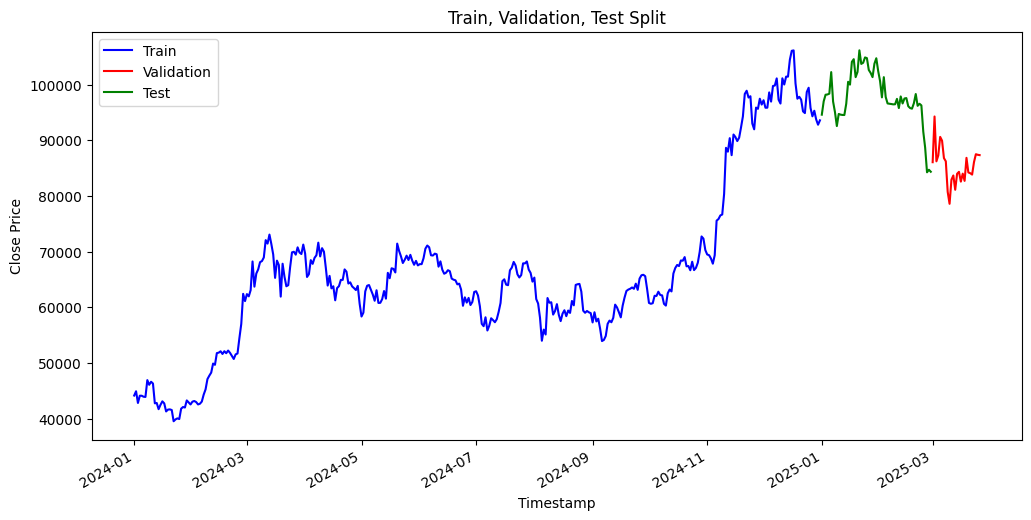

In [8]:
def visualize_train_test_split():
    plt.figure(figsize=(12, 6))
    plt.plot(train_data['timestamp'], train_data['close'], label='Train', color='blue')
    plt.plot(val_data['timestamp'], val_data['close'], label='Validation', color='red')
    plt.plot(test_data['timestamp'], test_data['close'], label='Test', color='green')
    plt.legend()
    plt.title("Train, Validation, Test Split")
    plt.xlabel('Timestamp')
    plt.ylabel('Close Price')
    plt.gcf().autofmt_xdate()  # Rotate date labels for better readability
    plt.show()
visualize_train_test_split()

In [9]:
# Plot BTC price development candlestick chart
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=data['timestamp'], open=data['open'], high=data['high'], low=data['low'], close=data['close'])])
fig.update_layout(title='BTC/USDT Price Development', xaxis_title='Date', yaxis_title='Price')
#theme minimal
fig.update_layout(template='simple_white')
fig.show()


### Hyperparameter Tuning

In [10]:
#all libraries
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV, cross_val_score, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from skopt import BayesSearchCV, gp_minimize
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from skopt.space import Real, Integer
import numpy as np
import matplotlib.pyplot as plt
import optuna

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Grid Search CV

In [11]:
def grid_search_cv():# Define the model
    model = XGBRegressor()

    # Define hyperparameters
    param_grid = {
        'max_depth': [5, 6, 7, 8, 9, 11, 13, 14],
        'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.2, 0.4, 0.7],
        'gamma': [0, 0.1, 0.2, 0.4, 0.8, 1.6],
        'reg_alpha': [0.4, 0.8, 1.6, 6.4],
        'reg_lambda': [0.4, 0.8, 1.6, 6.4]
    }

    # Perform grid search
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(train_data[features], train_data[targets[0]])


Random Search CV

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


860 fits failed out of a total of 1000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-pac

===== XGBoost Metric Evaluation ===== 
Best Hyperparameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 50, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Validation Mean Squared Error (MSE): 97188376.8440
Validation Mean Absolute Error (MAE): 9347.4683
Validation R-squared (R²): -8.2610
[0.46483448 0.0920334  0.16832662 0.05400895 0.00113892 0.01031735
 0.12124136 0.00090198 0.         0.00144899 0.00084368 0.00173629
 0.00104669 0.08094791 0.00117343]
XGBoost Feature Importances:
 open           0.464834
low            0.168327
SMA_10         0.121241
high           0.092033
close_lag_1    0.080948
close          0.054009
SMA_5          0.010317
MACD_signal    0.001736
EMA_9          0.001449
close_lag_2    0.001173
volume         0.001139
RSI            0.001047
SMA_15         0.000902
MACD           0.000844
SMA_30         0.000000
dtype: float32


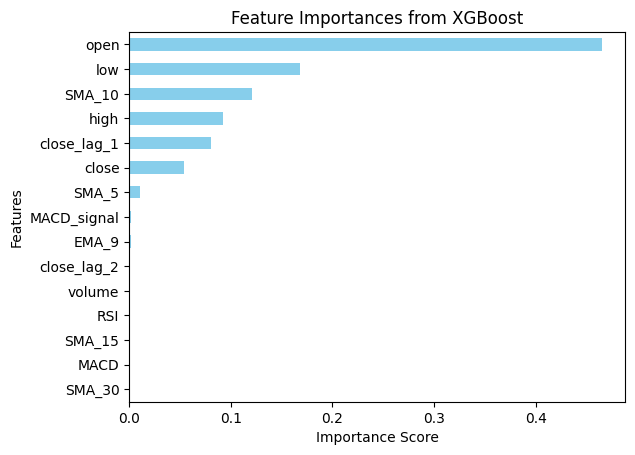

Selected Features: Index(['open', 'low', 'SMA_10', 'high', 'close_lag_1', 'close'], dtype='object')
Validation MSE: 101235323.27967365
Test MSE: 416520305.4671315


In [ ]:
# random search for best hyperparameters for XGBoost
def random_search():
    #define time-series cross validation
    tscv = TimeSeriesSplit(n_splits=10)

    # Define the model
    model = XGBRegressor(random_state = 42, tree_method='auto')

    param_grid = {
        'n_estimators': [50, 100, 200],  
        'learning_rate': [0.01, 0.05, 0.1, 0.2],  
        'max_depth': [3, 5, 7, 10],  
        'min_child_weight': [1, 3, 5],  
        'subsample': [0.6, 0.8, 1.0],  
        'colsample_bytree': [0.6, 0.8, 1.0],  
        'gamma': [0, 0.1, 0.2],  
        'reg_alpha': [0, 0.01, 0.1],  
        'reg_lambda': [1, 1.5, 2],  
    }

    # Perform random search
    random_search = RandomizedSearchCV(
        model, 
        param_grid, 
        n_iter=100, 
        cv=tscv, 
        n_jobs=-1,
        random_state=42,
        scoring='neg_mean_squared_error'
    )
    random_search.fit(X_train, y_train['close_1_ahead'])

    # Output the best hyperparameters
    best_params = random_search.best_params_
    print(f"===== XGBoost Metric Evaluation ===== ")
    print(f"Best Hyperparameters:", best_params)

    #Evaluate best model on validation set
    best_model = random_search.best_estimator_
    y_val_pred = best_model.predict(X_val)

    mse = mean_squared_error(y_val['close_1_ahead'], y_val_pred)
    mae = mean_absolute_error(y_val['close_1_ahead'], y_val_pred)
    r2 = r2_score(y_val['close_1_ahead'], y_val_pred)

    print(f"Validation Mean Squared Error (MSE): {mse:.4f}")
    print(f"Validation Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Validation R-squared (R²): {r2:.4f}")

    # Feature importance
    feature_importances = best_model.feature_importances_

    print(feature_importances)

    # Get feature importances as a Pandas Series
    feature_importances_xgb_rs = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    print("XGBoost Feature Importances:\n", feature_importances_xgb_rs)

    # Plot importance
    feature_importances_xgb_rs.sort_values(ascending=True).plot(kind='barh', color='skyblue')
    plt.title("Feature Importances from XGBoost")
    plt.xlabel("Importance Score")
    plt.ylabel("Features")
    plt.show()

    # Select important features (threshold > 0.05)
    selected_features_xgb_rs = feature_importances_xgb_rs[feature_importances_xgb_rs > 0.05].index
    print("Selected Features:", selected_features_xgb_rs)

    # **Train XGBRegressor using only the selected features**
    X_train_selected = X_train[selected_features_xgb_rs]
    X_val_selected = X_val[selected_features_xgb_rs]
    X_test_selected = X_test[selected_features_xgb_rs]

    xgb_rs = XGBRegressor(
        **best_params, 
        eval_metric='rmse', 
        #early_stopping_rounds=10
    )

    #eval_set = [(X_val_selected, y_val['close_1_ahead'])]
    
    # Train on selected features
    xgb_rs.fit(X_train_selected, y_train['close_1_ahead'], verbose=True)

    # Predict on validation data
    val_predictions_rs = xgb_rs.predict(X_val_selected)
    val_mse = mean_squared_error(y_val['close_1_ahead'], val_predictions_rs)
    print(f"Validation MSE: {val_mse}")

    # Predict on test data
    test_predictions_rs = xgb_rs.predict(X_test_selected)
    test_mse = mean_squared_error(y_test['close_1_ahead'], test_predictions_rs)
    print(f"Test MSE: {test_mse}")

    return val_predictions_rs, test_predictions_rs

val_predictions_rs, test_predictions_rs = random_search()

In [13]:
def line_plot(val_pred, test_pred):
    #Visualizing random search results
    plt.figure(figsize=(12, 6))
    plt.plot(val_data['timestamp'], y_val['close_1_ahead'], label='Actual Prices', color='blue')
    plt.plot(val_data['timestamp'], val_pred, label='Predicted Prices', color='red', linestyle='--')
    plt.title("Actual vs Predicted Prices (Validation Set)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

    # Plot for test set
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['timestamp'], y_test['close_1_ahead'], label='Actual Prices', color='blue')
    plt.plot(test_data['timestamp'], test_pred, label='Predicted Prices', color='green', linestyle='--')
    plt.title("Actual vs Predicted Prices (Test Set)")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.show()
#line_plot()


def residual_plot(val_pred, test_pred):
    val_residuals = val_data[targets[0]] - val_pred
    test_residuals = test_data[targets[0]] - test_pred
    # Plot residuals for validation set
    plt.figure(figsize=(12, 6))
    plt.scatter(val_pred, val_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Validation Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()

    # Plot residuals for test set
    plt.figure(figsize=(12, 6))
    plt.scatter(test_pred, test_residuals, alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.title("Residual Plot (Test Set)")
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.show()
#residual_plot()


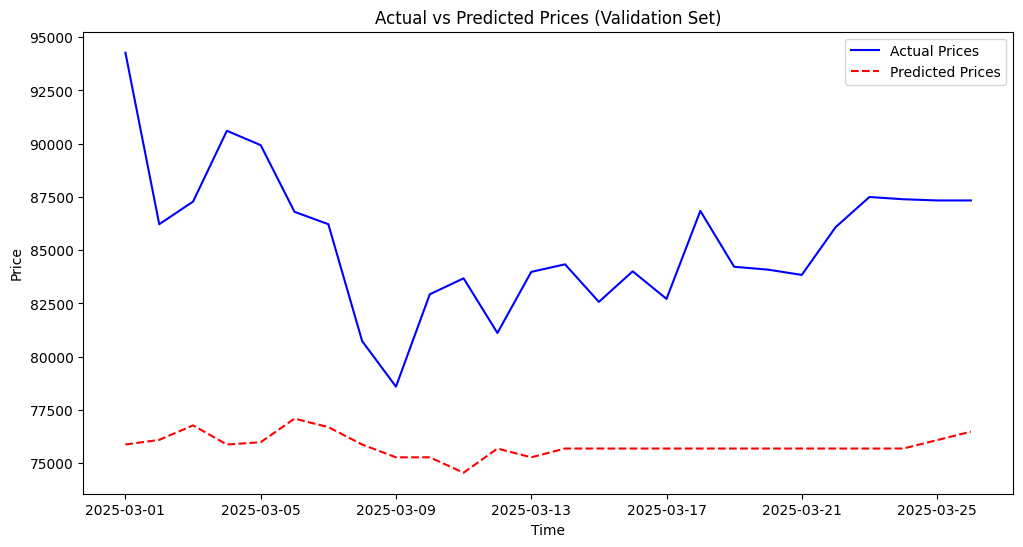

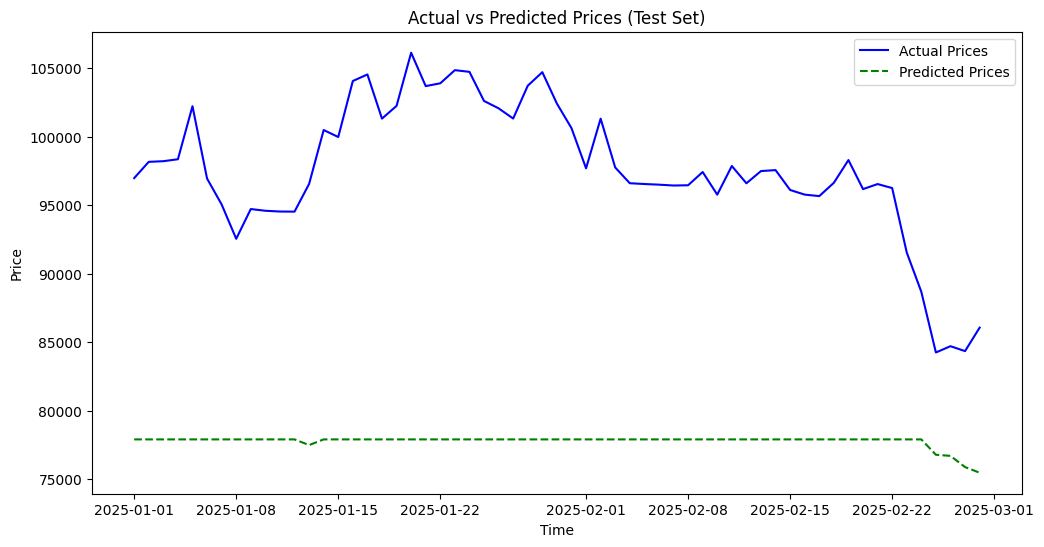

In [14]:
line_plot(val_predictions_rs, test_predictions_rs)

Bayesian Optimization

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, 5, 1.6, 0.4, 6.4] before, using random point [0.03796953219316154, 6, 0.20924989899785112, 2.900754683253536, 6.161380629431717]

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, 5, 1.6, 0.4, 6.4] before, using random point [0.01773083189909982, 14, 0.017951335197039245, 2.52508377229364, 1.7269682458779574]

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning:

The objective has been evaluated at point [0.7, 5, 1.6, 6.4, 6.4] before, using random point [0.2675566412973009, 13, 0.8458845619871509, 4.414379091003457, 4.994495153903268]

c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:

Validation MSE (gp_minimize): 17714607.014084436


c:\Users\ryant\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[13:09:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.


[I 2025-03-26 13:09:32,521] A new study created in memory with name: no-name-10ea8875-13cb-420a-93bd-ef22894a2e0e


Validation MSE (BayesSearchCV): 15122027.58009377


[I 2025-03-26 13:09:32,729] Trial 0 finished with value: 219926760.9815908 and parameters: {'learning_rate': 0.018862266180031315, 'max_depth': 11, 'gamma': 0.8972082029497642, 'reg_alpha': 2.200222546369329, 'reg_lambda': 5.106751731902701}. Best is trial 0 with value: 219926760.9815908.
[I 2025-03-26 13:09:33,049] Trial 1 finished with value: 183973813.47037047 and parameters: {'learning_rate': 0.21311189629623353, 'max_depth': 9, 'gamma': 1.3035608739167408, 'reg_alpha': 3.9018111219511007, 'reg_lambda': 3.2537712032224504}. Best is trial 1 with value: 183973813.47037047.
[I 2025-03-26 13:09:33,326] Trial 2 finished with value: 185048329.57395667 and parameters: {'learning_rate': 0.049828583487607436, 'max_depth': 10, 'gamma': 0.5303071921704309, 'reg_alpha': 2.834652679067877, 'reg_lambda': 2.5416743586287347}. Best is trial 1 with value: 183973813.47037047.
[I 2025-03-26 13:09:33,634] Trial 3 finished with value: 187942340.2309963 and parameters: {'learning_rate': 0.11330020697627

Validation MSE (Optuna): 28166235.014781274
Best method: BayesSearchCV
Best parameters: OrderedDict({'gamma': 1.6, 'learning_rate': 0.5345066173209511, 'max_depth': 6, 'reg_alpha': 0.4, 'reg_lambda': 5.307085557029259})
Validation MSE: 15122027.58009377
Test MSE (Final Model): 14914573.37342169


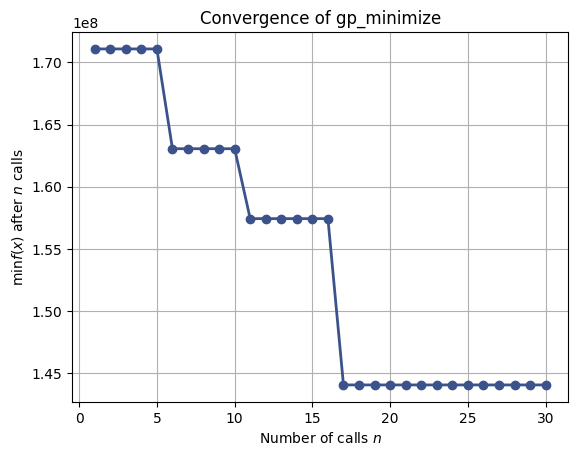

In [15]:
# Define the model
model = XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

tscv = TimeSeriesSplit(n_splits = 5)

# Define the search space for hyperparameters (in a list for gp_minimize)
search_space = [
    Real(0.01, 0.7, name='learning_rate', prior='log-uniform'),
    Integer(5, 14, name='max_depth'),
    Real(0, 1.6, name='gamma'),
    Real(0.4, 6.4, name='alpha'),
    Real(0.4, 6.4, name='lambda_')
]

# Convert search_space to a dictionary for BayesSearchCV
search_space_dict = {
    'learning_rate': Real(0.01, 0.7, prior='log-uniform'),
    'max_depth': Integer(5, 14),
    'gamma': Real(0, 1.6),
    'reg_alpha': Real(0.4, 6.4),
    'reg_lambda': Real(0.4, 6.4)
}

# Define the objective function for gp_minimize
@use_named_args(search_space)
def objective(learning_rate, max_depth, gamma, alpha, lambda_):
    # Set the model parameters
    model.set_params(
        learning_rate=learning_rate,
        max_depth=max_depth,
        gamma=gamma,
        alpha=alpha,
        lambda_=lambda_
    )
    scores = cross_val_score(model, X_train, train_data["close_1_ahead"], 
                             cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
    
    return -np.mean(scores) 

# Step 1: Optimize the mathematical function using gp_minimize
result = gp_minimize(
    func=objective,
    dimensions=search_space,
    n_calls=30,
    n_initial_points=10,
    acq_func="EI",
    random_state=42
)

# Best parameters from gp_minimize
best_params_gp = {
    'learning_rate': result.x[0],
    'max_depth': int(result.x[1]),
    'gamma': result.x[2],
    'alpha': result.x[3],
    'lambda': result.x[4]
}

#evaluate gp_minimize parameters
model_gp = XGBRegressor(**best_params_gp, objective='reg:squarederror', n_estimators=50, random_state=42)
model_gp.fit(X_train, y_train["close_1_ahead"])
val_predictions_gp = model_gp.predict(X_val)
mse_gp = mean_squared_error(y_val['close_1_ahead'], val_predictions_gp)
print(f"Validation MSE (gp_minimize): {mse_gp}")


# Step 2: Optimize hyperparameters using BayesSearchCV
opt = BayesSearchCV(
    model,
    search_space_dict,
    n_iter=50,
    cv=tscv,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    random_state=42
)

opt.fit(X_train, y_train["close_1_ahead"])

# Best parameters from BayesSearchCV
best_params_bayescv = opt.best_params_
val_predictions_bayescv = opt.predict(X_val)
mse_bayescv = mean_squared_error(y_val['close_1_ahead'], val_predictions_bayescv)
print(f"Validation MSE (BayesSearchCV): {mse_bayescv}")

def objective_optuna(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.7, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 14),
        'gamma': trial.suggest_float('gamma', 0, 1.6),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.4, 6.4),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.4, 6.4)
    }
    model = XGBRegressor(**params, objective='reg:squarederror', n_estimators=50, random_state=42)
    scores = cross_val_score(model, X_train, y_train["close_1_ahead"], 
                             cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return -np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective_optuna, n_trials=50)

best_params_optuna = study.best_params
model_optuna = XGBRegressor(**best_params_optuna, objective='reg:squarederror', n_estimators=50, random_state=42)
model_optuna.fit(X_train, y_train["close_1_ahead"])
val_predictions_optuna = model_optuna.predict(X_val)
mse_optuna = mean_squared_error(y_val['close_1_ahead'], val_predictions_optuna)
print(f"Validation MSE (Optuna): {mse_optuna}")

# Step 4: Compare results and select the best parameters
results = {
    'gp_minimize': {'params': best_params_gp, 'mse': mse_gp},
    'BayesSearchCV': {'params': best_params_bayescv, 'mse': mse_bayescv},
    'Optuna': {'params': best_params_optuna, 'mse': mse_optuna}
}

best_method = min(results, key=lambda k: results[k]['mse'])
best_params_final = results[best_method]['params']
print(f"Best method: {best_method}")
print(f"Best parameters: {best_params_final}")

# Step 5: Train the final model with the best parameters
final_model = XGBRegressor(**best_params_final, objective='reg:squarederror', n_estimators=50, random_state=42)
final_model.fit(X_train, y_train["close_1_ahead"])


#Evaluate model on val set
val_predictions_bayes = final_model.predict(X_val)
val_mse = mean_squared_error(y_val['close_1_ahead'], val_predictions_bayes)
print(f"Validation MSE: {val_mse}")

# Evaluate the final model on the test set
test_predictions_bayes = final_model.predict(test_data[features])
test_mse = mean_squared_error(y_test['close_1_ahead'], test_predictions_bayes)
print(f"Test MSE (Final Model): {test_mse}")

# Plot convergence of gp_minimize
from skopt.plots import plot_convergence
plot_convergence(result)
plt.title("Convergence of gp_minimize")
plt.show()

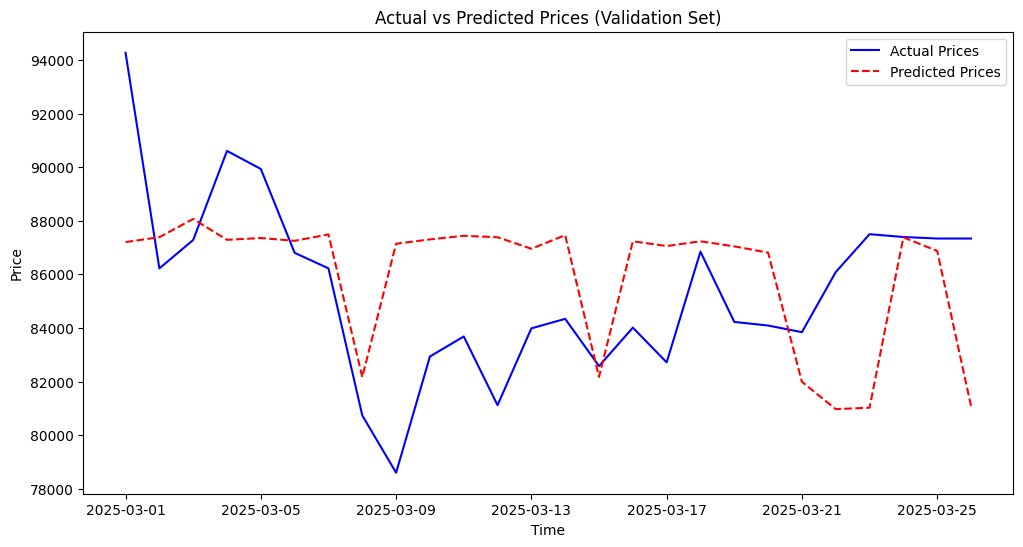

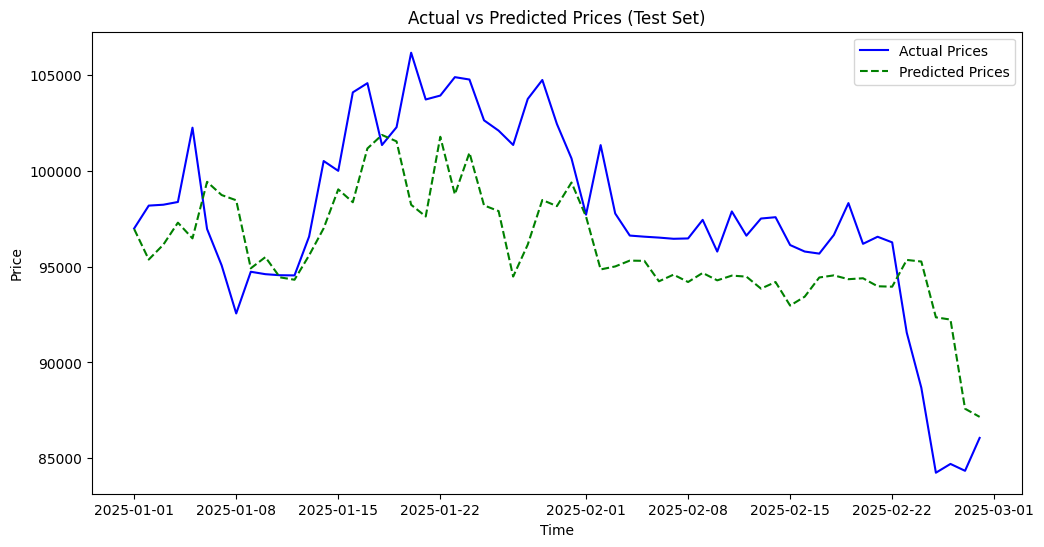

In [16]:
line_plot(val_predictions_bayes, test_predictions_bayes)

### Develop Trading Strategy

In [ ]:
# Predict future prices
train_data['Pred_1_day'] = model.predict(train_data[features])
val_data['Pred_1_day'] = model.predict(val_data[features])
test_data['Pred_1_day'] = model.predict(test_data[features])


NotFittedError: need to call fit or load_model beforehand

: 

In [48]:
from skopt import gp_minimize

# Define the objective function for weight optimization
def objective(weights):
    # Combine predictions using the weights
    combined_pred = (weights[0] * train_data['Pred_1_day'] +
                     weights[1] * train_data['Pred_2_day'] +
                     weights[2] * train_data['Pred_5_day'] +
                     weights[3] * train_data['Pred_10_day'] +
                     weights[4] * train_data['Pred_20_day'] +
                     weights[5] * train_data['Pred_30_day'])
    
    # Calculate the Sharpe ratio (or any other metric)
    returns = combined_pred.pct_change().dropna()
    sharpe_ratio = returns.mean() / returns.std()
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

# Define the search space for weights
weight_space = [(0, 1) for _ in range(6)]

# Bayesian Optimization for weight optimization
res = gp_minimize(objective, weight_space, n_calls=50, random_state=42)
best_weights = res.x

KeyError: 'Pred_2_day'

# LINEAR REGRESSION

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [5]:
df = btc_data.copy()

In [6]:
df.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume', 'SMA_5',
       'SMA_10', 'SMA_15', 'SMA_30', 'EMA_9', 'RSI', 'MACD', 'MACD_signal',
       'MACD_hist', 'close_lag_1', 'close_lag_2', 'close_1_ahead',
       'close_2_ahead', 'close_5_ahead', 'close_10_ahead', 'close_20_ahead',
       'close_30_ahead', 'log_return', 'return_1'],
      dtype='object')

In [7]:
# generate more features


# high_t - low_t – daily range (volatility)
df['daily_range'] = df['high'] - df['low']

#close_t - open_t – daily momentum
df['daily_momentum'] = df['open'] - df['close']

# rolling_mean_3 – 3-day moving average of close
df['rolling_mean_3'] = df['close'].rolling(window=3).mean()

# rolling_std_3 – 3-day rolling standard deviation
df['rolling_std_3'] = df['close'].rolling(window=3).std()

# day_of_week – encoded as number (0=Monday, ..., 6=Sunday)
df['day_of_week'] = df['timestamp'].dt.dayofweek

df['next_day_close'] = df['close'].shift(-1)

df['return_1'] = (df['next_day_close'] - df['close']) / df['close']



In [8]:
# Drop NaN rows
df = df.dropna().reset_index(drop=True)

# Preview updated dataset
print(df[['timestamp', 'close', 'next_day_close'] + 
         ['daily_range', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'return_1']].head())


   timestamp     close  next_day_close  daily_range  daily_momentum  \
0 2024-01-03  42845.23        44151.10      4750.00         2101.68   
1 2024-01-04  44151.10        44145.11      2115.81        -1305.87   
2 2024-01-05  44145.11        43968.32      1907.46            5.99   
3 2024-01-06  43968.32        43929.02       817.37          176.80   
4 2024-01-07  43929.02        46951.04       908.50           39.30   

   rolling_mean_3  rolling_std_3  day_of_week  return_1  
0    43990.563333    1063.509133            2  0.030479  
1    43981.080000    1061.105464            3 -0.000136  
2    43713.813333     752.221194            4 -0.004005  
3    44088.176667     103.842118            5 -0.000894  
4    44014.150000     115.104360            6  0.068793  


In [11]:
# Extract month from timestamp
train_end_date = pd.to_datetime('2024-10-31')
val_end_date = pd.to_datetime('2024-12-31')

train_df = df[df['timestamp'] < train_end_date]
val_df = df[(df['timestamp'] >= train_end_date) & (df['timestamp'] < val_end_date)]
test_df = df[df['timestamp'] >= val_end_date]

# Define features and target
features = ['close', 'daily_range', 'daily_momentum', 'rolling_mean_3', 'rolling_std_3', 'day_of_week', 'return_1']
target = 'next_day_close'

# Extract input/output sets
X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]
X_test, y_test = test_df[features], test_df[target]


Validation MAE: 609.42
Validation RMSE: 837.71
Test MAE: 626.60
Test RMSE: 856.77


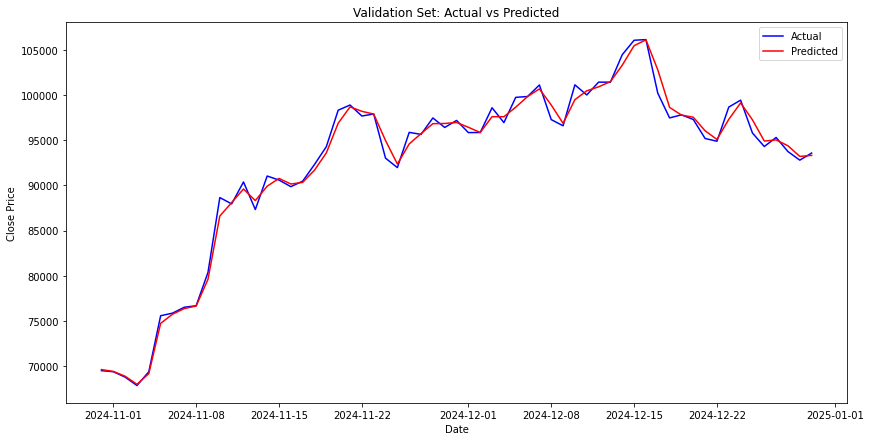

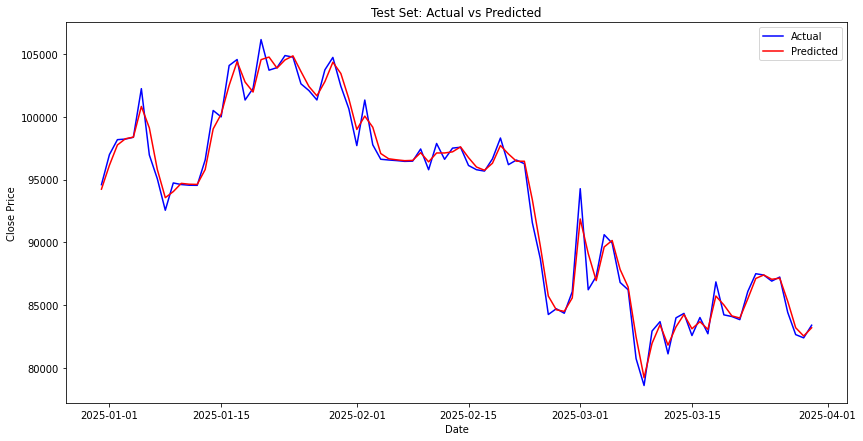

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Initialize and fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on validation and test sets
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Evaluation metrics
def evaluate(y_true, y_pred, name="Set"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{name} MAE: {mae:.2f}")
    print(f"{name} RMSE: {rmse:.2f}")

# Evaluate
evaluate(y_val, val_preds, name="Validation")
evaluate(y_test, test_preds, name="Test")

# Plot predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(val_df['timestamp'], y_val, label='Actual', color='blue')
plt.plot(val_df['timestamp'], val_preds, label='Predicted', color='red')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot predictions vs actual values for test set
plt.figure(figsize=(14, 7))
plt.plot(test_df['timestamp'], y_test, label='Actual', color='blue')
plt.plot(test_df['timestamp'], test_preds, label='Predicted', color='red')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# NLinear and DLinear

In [18]:
from linear_models import NLinear, DLinear
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [19]:
def create_sequences(data, seq_length=7, pred_len=1):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_len + 1):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length:i + seq_length + pred_len])
    return np.array(X), np.array(y)

close_data = df[['close']].values

X, y = create_sequences(close_data, seq_length=7, pred_len=1)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

n = len(X_tensor)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

X_train, X_val, X_test = X_tensor[:train_end], X_tensor[train_end:val_end], X_tensor[val_end:]
y_train, y_val, y_test = y_tensor[:train_end], y_tensor[train_end:val_end], y_tensor[val_end:]

seq_len = 7
pred_len = 1
enc_in = 1

model_D = DLinear(seq_len=seq_len, pred_len=pred_len, enc_in=enc_in)  # or NLinear

    

In [ ]:
import torch.optim as optim

optimizer = optim.Adam(model_D.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

epochs = 100
for epoch in range(epochs):
    model_D.train()
    optimizer.zero_grad()
    
    output = model_D(X_train)
    loss = loss_fn(output, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model_D.eval()
        val_loss = loss_fn(model(X_val), y_val).item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")


TypeError: 'LinearRegression' object is not callable

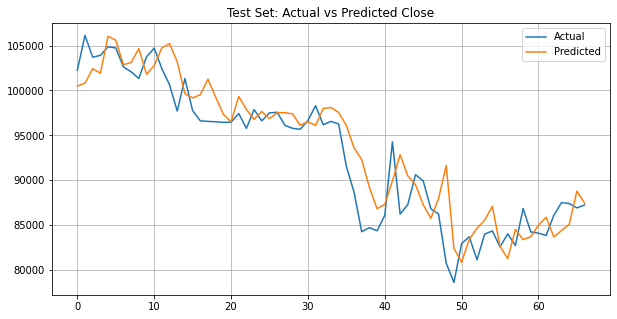

In [22]:
model.eval()
preds = model(X_test).detach().numpy()
actuals = y_test.numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actuals.flatten(), label='Actual')
plt.plot(preds.flatten(), label='Predicted')
plt.title('Test Set: Actual vs Predicted Close')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model_N = NLinear(seq_len=seq_len, pred_len=pred_len, enc_in=enc_in)

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model_N.parameters(), lr=0.005)
loss_fn = torch.nn.MSELoss()

epochs = 100
for epoch in range(epochs):
    model_N.train()
    optimizer.zero_grad()
    
    output = model(X_train)
    loss = loss_fn(output, y_train)
    
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        model_N.eval()
        val_loss = loss_fn(model(X_val), y_val).item()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f} - Val Loss: {val_loss:.4f}")


Epoch 10/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 20/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 30/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 40/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 50/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 60/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 70/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 80/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 90/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000
Epoch 100/100 - Train Loss: 5982162.5000 - Val Loss: 8558916.0000


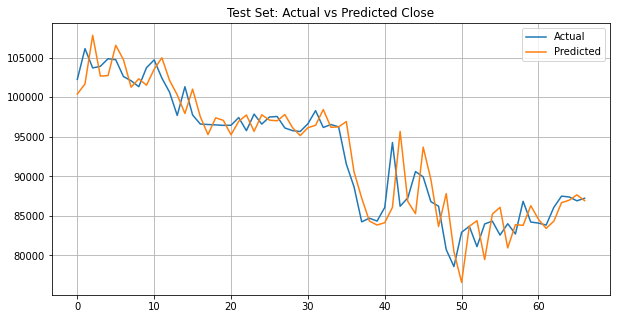

In [25]:
model_N.eval()
preds = model_N(X_test).detach().numpy()
actuals = y_test.numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actuals.flatten(), label='Actual')
plt.plot(preds.flatten(), label='Predicted')
plt.title('Test Set: Actual vs Predicted Close')
plt.legend()
plt.grid(True)
plt.show()


### Evaluation

In [ ]:
# Buy & Hold strategy
test_data['Buy_Hold_Returns'] = test_data['Close'].pct_change()
test_data['Cumulative_Buy_Hold_Returns'] = (1 + test_data['Buy_Hold_Returns']).cumprod()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(test_data['Cumulative_Strategy_Returns'], label='Trading Strategy')
plt.plot(test_data['Cumulative_Buy_Hold_Returns'], label='Buy & Hold')
plt.legend()
plt.show()